## Analysis Challenge Assignment 2

**Author**: Nicolás Dussaillant<br />
Core Methods in Educational Data Mining

The following information shows the process of the search for a classification algorithm that can predict when children are working On-task or Off-task based on a list of observations with different variables that might be used as predictors.

## 1. Import data

In [1]:
import pandas as pd

cols = [
        'SCHOOL',
        'GRADE',
        'CODER',
        'Gender',
        'OBSNUM',
        'totalobs-forsession',
        'Activity',
        'ONTASK',
        'TRANSITIONS',
        'FORMATchanges',
        'Obsv/act',
        'Transitions/Durations',
        'Total Time'
        ]
df = pd.read_csv('aca2_dataset/aca2_dataset_training.csv', usecols = cols)
dv = pd.read_csv('aca2_dataset/aca2_dataset_validation.csv', usecols = cols)

## 2. Analyze data

Check On-task and Off-task data

In [5]:
print(df.ONTASK.value_counts())
df.ONTASK.value_counts(normalize = True)

Y    14938
N     7246
Name: ONTASK, dtype: int64


Y    0.673368
N    0.326632
Name: ONTASK, dtype: float64

Check On- and Off-task against the categorical variables

In [17]:
display(pd.crosstab(df.ONTASK, df.SCHOOL, normalize='columns'))
display(pd.crosstab(df.ONTASK, df.CODER, normalize='columns'))
display(pd.crosstab(df.ONTASK, df.GRADE, normalize='columns'))
display(pd.crosstab(df.ONTASK, df.Gender, normalize='columns'))
display(pd.crosstab(df.ONTASK, df.Activity, normalize='columns'))

SCHOOL,A,B,C,D,E
ONTASK,,,,,
N,0.311119,0.320979,0.289194,0.346372,0.377336
Y,0.688881,0.679021,0.710806,0.653628,0.622664


CODER,Y,Z
ONTASK,,
N,0.291753,0.328227
Y,0.708247,0.671773


GRADE,0,1,2,3,4
ONTASK,,,,,
N,0.2854,0.3344,0.322007,0.284287,0.365805
Y,0.7146,0.6656,0.677993,0.715713,0.634195


Gender,0,1
ONTASK,,
N,0.348251,0.305563
Y,0.651749,0.694437


Activity,Dancing,Individual,Smallgroup,Testing,Wholecarpet,Wholedesks
ONTASK,,,,,,
N,0.222222,0.344987,0.291262,0.23913,0.313043,0.353863
Y,0.777778,0.655013,0.708738,0.76087,0.686957,0.646137


In [20]:
display(pd.crosstab([df.SCHOOL, df.GRADE, df.Gender], df.ONTASK, normalize='index'))

ONTASK                      N         Y
SCHOOL GRADE Gender                    
A      0     0       0.302772  0.697228
             1       0.339152  0.660848
       1     0       0.352638  0.647362
             1       0.296435  0.703565
       2     0       0.345009  0.654991
             1       0.346614  0.653386
       4     0       0.319244  0.680756
             1       0.253585  0.746415
B      0     0       0.313462  0.686538
             1       0.308824  0.691176
       1     0       0.361502  0.638498
             1       0.327354  0.672646
       2     0       0.277886  0.722114
             1       0.221640  0.778360
       3     0       0.367059  0.632941
             1       0.272876  0.727124
       4     0       0.395232  0.604768
             1       0.355623  0.644377
C      0     0       0.248344  0.751656
             1       0.221973  0.778027
       1     0       0.369658  0.630342
             1       0.320939  0.679061
       2     0       0.470738  0.529262
             1       0.296610  0.703390
       3     0       0.234884  0.765116
             1       0.263473  0.736527
       4     0       0.230906  0.769094
             1       0.228986  0.771014
D      0     0       0.253886  0.746114
             1       0.324503  0.675497
       2     0       0.309568  0.690432
             1       0.270609  0.729391
       4     0       0.486631  0.513369
             1       0.404000  0.596000
E      0     0       0.310030  0.689970
             1       0.240688  0.759312
       1     0       0.336170  0.663830
             1       0.299435  0.700565
       2     0       0.367220  0.632780
             1       0.357414  0.642586
       4     0       0.634434  0.365566
             1       0.495798  0.504202

Check numerical variables against On- and Off-task

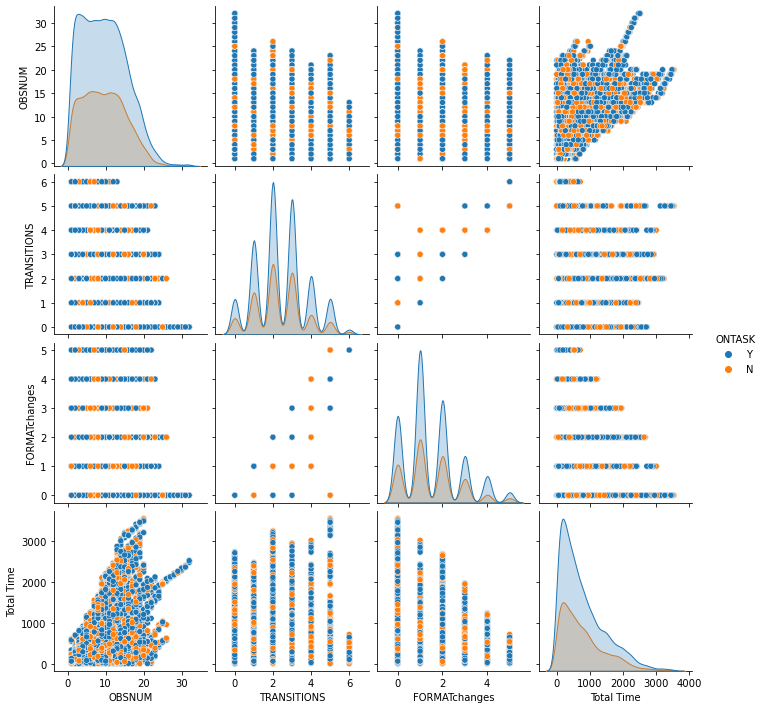

In [11]:
import seaborn as sns

sns.pairplot(df[['OBSNUM', 'ONTASK', 'TRANSITIONS', 'FORMATchanges', 'Total Time']], hue = 'ONTASK')

#### Analysis:
Apparently there are no very clear distinctions to predict the On-task behavior of children. So let's prepare the data and do some regressions to test the potential power of that.

**Validation data:**

In [52]:
print(dv.ONTASK.value_counts())
dv.ONTASK.value_counts(normalize = True)

Y    3698
N    1849
Name: ONTASK, dtype: int64


Y    0.666667
N    0.333333
Name: ONTASK, dtype: float64

## 3. Prediction

In the subsections below are different methods that were tested to try to achieve a good prediction. Each method includes its data preparation, data processing, prediction and results

In [6]:
# Import the packages that will be used in all the processes:
from sklearn.linear_model import LogisticRegression
from patsy import dmatrices # If you have Statsmodels this package should've been installed with it.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.naive_bayes import BernoulliNB

### 3.1 Logistic regression
In this subsection we will try to make a logistic regression changing all the categorical variables into dummy coding and see what happens.

#### 3.1.1 Data preparation

In [7]:
#Define a function to prepare data for this case and that will be useful for the validation data and other methods
def prepare_data(df):
    dfx = df.loc[:, df.columns != 'ONTASK']
    # Encode dummy variables (Gender is not included because it is already encoded)
    Xs = pd.get_dummies(dfx, columns = ['SCHOOL', 'GRADE', 'CODER', 'Activity'])

    # Format ONTASK as binary
    Y = df['ONTASK'].replace(to_replace = ['Y', 'N'], value = [1, 0])
    return Xs, Y

With this way of prepareing data we get a total of 26 variables

#### 3.1.2 Model fitting

In [10]:
Xs, Y = prepare_data(df)

logit = LogisticRegression()
logit.fit(Xs, Y)

#### 3.1.3 Prediction for training and validation data

In [13]:
pred_logit = logit.predict(Xs)

Xtest, Ytest = prepare_data(dv)
pred_test = logit.predict(Xtest)

#### 3.1.4 Results

In [18]:
print('Training data')
print('Accuracy: ', accuracy_score(Y, pred_logit))
print('Confusion matrix: \n', confusion_matrix(Y, pred_logit))

print('\n')

print('Validation data')
print('Accuracy: ', accuracy_score(Ytest, pred_test))
print('Confusion matrix: \n', confusion_matrix(Ytest, pred_test))

Training data
Accuracy:  0.6736386584926073
Confusion matrix: 
 [[    7  7239]
 [    1 14937]]


Validation data
Accuracy:  0.6666666666666666
Confusion matrix: 
 [[   0 1849]
 [   0 3698]]


### 3.2 Logistic regression with feature selection

In this section we will use the same data than with the last section but we will select the features that give the best prediction. For this we will use the RFECV object available with Scikit Learn to recursively search for the best combination of variables (the execution time could take a bit of time).

#### 3.2.1 Data preparation
We will use the same data used in the original Logistic Regression.

#### 3.2.2 Model fitting

In [24]:
logit2 = LogisticRegression(max_iter = 500) # Increment number of iterations to let it achieve the optimal fitting

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=logit2, step=1, cv=None,
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
rfecv.fit(Xs, Y)

print("Optimal number of features : %d" % rfecv.n_features_, ' / 26')

# We print the variables selected by rfecv
print("\nExcluded variables:")
predictors = rfecv.support_
for i in range(0, len(predictors)):
    if not predictors[i]:
        print(Xs.columns[i])

Optimal number of features : 21  / 26

Excluded variables:
OBSNUM
totalobs-forsession
Obsv/act
Total Time
SCHOOL_D


#### 3.2.3 Prediction for training and validation data

In [25]:
Yrfe = rfecv.predict(Xs)
Yrfetest = rfecv.predict(Xtest)

#### 3.2.4 Results

In [26]:
print('Training data')
print('Accuracy: ', accuracy_score(Y, Yrfe))
print('Confusion matrix: \n', confusion_matrix(Y, Yrfe))

print('\n')

print('Validation data')
print('Accuracy: ', accuracy_score(Ytest, Yrfetest))
print('Confusion matrix: \n', confusion_matrix(Ytest, Yrfetest))

Training data
Accuracy:  0.676613775694194
Confusion matrix: 
 [[  143  7103]
 [   71 14867]]


Validation data
Accuracy:  0.668108887687038
Confusion matrix: 
 [[  32 1817]
 [  24 3674]]


### 3.3 Naive Bayes (Bernoulli) with feature selection
In this subsection we will implement the Bernoulli approach to Naive Bayes method. We'll also add feature selection with RFECV.

#### 3.3.1 Data preparation
Same data as previous sections.

#### 3.3.2 Model fitting

In [30]:
# We disable warnings because for the version used in sklearn will be a change in a variable name and it is being announced
import warnings
warnings.filterwarnings('ignore')

nb_model = BernoulliNB()

min_features_to_select = 1  # Minimum number of features to consider
nb_rfecv = RFECV(estimator=nb_model, step=1, cv=None,
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
nb_rfecv.fit(Xs, Y)

print("Optimal number of features : %d" % nb_rfecv.n_features_, ' / 26')

# We print the variables selected by rfecv
print("\nExcluded variables:")
predictors = nb_rfecv.support_
for i in range(0, len(predictors)):
    if not predictors[i]:
        print(Xs.columns[i])

Optimal number of features : 23  / 26

Excluded variables:
OBSNUM
totalobs-forsession
Obsv/act


#### 3.3.3 Prediction for training and validation data

In [31]:
Ynbrfe = nb_rfecv.predict(Xs)
Ynbrfetest = nb_rfecv.predict(Xtest)

#### 3.3.4 Results

In [32]:
print('Training data')
print('Accuracy: ', accuracy_score(Y, Ynbrfe))
print('Confusion matrix: \n', confusion_matrix(Y, Ynbrfe))

print('\n')

print('Validation data')
print('Accuracy: ', accuracy_score(Ytest, Ynbrfetest))
print('Confusion matrix: \n', confusion_matrix(Ytest, Ynbrfetest))

Training data
Accuracy:  0.6766588532275514
Confusion matrix: 
 [[  157  7089]
 [   84 14854]]


Validation data
Accuracy:  0.6677483324319452
Confusion matrix: 
 [[  34 1815]
 [  28 3670]]


### 3.4 Logistic Regression with interactions
For this model we will create interactions between categorical variables encoded as dummy variables and the continous variables. This will consider the effects of continuous variables differently for each case of categorical variables

#### 3.4.1 Data preparation
For this method we will prepare the data using the Patsy package, it will allow us to rapidly create the interaction variables. The problem is that this will create 4,800 different variables and for processing time and other factors I wasn't able to refine the search for the most important.

In [37]:
# Change variable names and create the distinction between categorical and continuous variables
column_changes = { 'Total Time' : 'Total_time', 
                        'totalobs-forsession' : 'totalobs_forsession',
                        'Obsv/act' : 'Obsv_act',
                        'Transitions/Durations' : 'Transitions_Durations'}
df_int = df.rename(columns = column_changes)
dv_int = dv.rename(columns = column_changes)

cat_vars = ['SCHOOL', 'GRADE', 'CODER', 'Activity', 'Gender']
cont_vars = ['OBSNUM', 'totalobs_forsession','TRANSITIONS','FORMATchanges', 'Obsv_act', 'Transitions_Durations', 'Total_time']

Now we will create the Patsy string that will have the following format (assuming 2 categorical variables CatA and CatB with 2 categories each, and 2 continuous variables ContA and ContB):<br />
"Y ~ (CatA * CatB) / (ContA + ContB)"<br />
and translates into this columns:<br />
Y | CatA_2 | CatB_2 | CatA_2 * CatB_2 | <br />
ContA | CatA_2 * ContA | CatB_2 * ContA | CatA_2 * CatB_2 * ContA | <br />
ContB | CatA_2 * ContB | CatB_2 * ContB | CatA_2 * CatB_2 * ContB
<br />
<br />
For each continuous variable we substract its mean to improve the performance of the model fitting

In [34]:
patsy_str = 'ONTASK ~ ('

for c in cat_vars:
    patsy_str += 'C(' + c + ')' + (' * ' if c != 'Gender' else ') / (')

for c in cont_vars:
    patsy_str += '(' + c + ' - np.mean(' + c + '))' + (' + ' if c != 'Total_time' else ')')
    
print(patsy_str)

ONTASK ~ (C(SCHOOL) * C(GRADE) * C(CODER) * C(Activity) * C(Gender)) / ((OBSNUM - np.mean(OBSNUM)) + (totalobs_forsession - np.mean(totalobs_forsession)) + (TRANSITIONS - np.mean(TRANSITIONS)) + (FORMATchanges - np.mean(FORMATchanges)) + (Obsv_act - np.mean(Obsv_act)) + (Transitions_Durations - np.mean(Transitions_Durations)) + (Total_time - np.mean(Total_time)))


Do this for training and validation data (this step could take a while)

In [39]:
ontask, X_int = dmatrices(patsy_str, data=df_int, return_type='dataframe')
y_int = ontask ['ONTASK[Y]']

ontask_test, X_int_test = dmatrices(patsy_str, data=dv_int, return_type='dataframe')
y_int_test = ontask_test ['ONTASK[Y]']

#### 3.4.2 Model fitting
We will augment the maximum iterations to improve the accuracy, but it has so many variables that it won't achieve the optimal model, however it can be good enough. This code will take several minutes of execution.

In [40]:
logit_int = LogisticRegression(max_iter = 10000, tol=1e-4)


logit_int.fit(X_int, y_int)

LogisticRegression(max_iter=10000)

(As the warnings were turned off, this piece of code is not telling that the optimal model wasn't achieved)

#### 3.4.3 Predictions

In [42]:
y_int_pred = logit_int.predict(X_int)
y_int_pred_test = logit_int.predict(X_int_test)

#### 3.4.4 Results

In [43]:
print('Training data')
print('Accuracy: ', accuracy_score(y_int, y_int_pred))
print('Confusion matrix: \n', confusion_matrix(y_int, y_int_pred))

print('\n')

print('Validation data')
print('Accuracy: ', accuracy_score(y_int_test, y_int_pred_test))
print('Confusion matrix: \n', confusion_matrix(y_int_test, y_int_pred_test))

Training data
Accuracy:  0.6945546339704292
Confusion matrix: 
 [[ 1350  5896]
 [  880 14058]]


Validation data
Accuracy:  0.6704524968451415
Confusion matrix: 
 [[ 276 1573]
 [ 255 3443]]


### 3.5 Logistic Regression with interactions
Here we will do the same as the previous model, but we will change the optimization algorithm for the logistic regression. This will improve processing performance, but it will make loss of accuracy.

#### 3.5.1 Data preparation
Same as the previous model, but the solver needs preprocessed variables, so we will use MinMax standardization

In [48]:
scaler = MinMaxScaler()
scaler.fit(X_int)
X_int_st = scaler.transform(X_int)

scalertest = MinMaxScaler()
scalertest.fit(X_int_test)
X_int_st_test = scalertest.transform(X_int_test)

#### 3.5.2 Model fitting
We will use the 'sag' method.

In [47]:
logit_int_sag = LogisticRegression(max_iter = 10000, tol=1e-4, solver = 'sag')
logit_int_sag.fit(X_int_st, y_int)

LogisticRegression(max_iter=10000, solver='sag')

#### 3.5.3 Prediction


In [49]:
y_int_pred_st = logit_int_sag.predict(X_int)
y_int_pred_test_st = logit_int_sag.predict(X_int_st_test)

#### 3.5.4 Results

In [50]:
print('Training data')
print('Accuracy: ', accuracy_score(y_int, y_int_pred_st))
print('Confusion matrix: \n', confusion_matrix(y_int, y_int_pred_st))

print('\n')

print('Validation data')
print('Accuracy: ', accuracy_score(y_int_test, y_int_pred_test_st))
print('Confusion matrix: \n', confusion_matrix(y_int_test, y_int_pred_test_st))

Training data
Accuracy:  0.49580778939776415
Confusion matrix: 
 [[4950 2296]
 [8889 6049]]


Validation data
Accuracy:  0.6765819361817198
Confusion matrix: 
 [[ 239 1610]
 [ 184 3514]]


## 4. Results
The following tables summarizes the results obtained in each model (On-task and Off-task rows are the True predictions for each classification):

|          | Training data | Logistic Regression | LogReg with RFECV | Bernoulli with RFECV | LogReg with interactions | LogReg w/int alt solver |
|----------|---------------|---------------------|-------------------|----------------------|--------------------------|-------------------------|
| Accuracy | 100%          | 67.36%              | 67.66%            | 67.67%               | 69.46%                   | 49.58%                  |
| On-task  | 14938         | 14937               | 14867             | 14854                | 14058                    | 6049                    |
| Off-task | 7246          | 7                   | 143               | 157                  | 1350                     | 4950                    |

|          | Training data | Logistic Regression | LogReg with RFECV | Bernoulli with RFECV | LogReg with interactions | LogReg w/int alt solver |
|----------|---------------|---------------------|-------------------|----------------------|--------------------------|-------------------------|
| Accuracy | 100%          | 66.67%              | 66.81%            | 66.77%               | 67.04%                   | 67.66%                  |
| On-task  | 3698          | 3698                | 3674              | 3670                 | 3443                     | 3514                    |
| Off-task | 1849          | 0                   | 32                | 34                   | 276                      | 239                     |

## 5. Comments / Discussion

The model with the best performance was the Logistic Regression with dummy coding and interactions. However, none of the methods have a very good accuracy, considering that the On-task results are approximately 67% and the best performance is 69.5% in training data and 67.7% in validation data. This means that the model only gets slightly better predictions than saying that all the observations are students on task. Nonetheless, the importance of the prediction is to find the children that are off task, and for that this models can help a little bit more than saying that all students are on task.<br />
This shows us that not every dataset will perform and predict as we would want, and that there are several methods that can be tested (these aren't the only methods I tested, they're just a few) and that will perform differently. <br />
Further works and improvements can be made, especially in the selection of the predictors and adjusting for Student ID (something that was left apart for this approach).